# Backpropagation

In this demo, we will implement backpropagation from scratch. We will follow the colab notebook that accompanies Boaz Barak's excellent [Yet another backpropagation tutorial](https://windowsontheory.org/2020/11/03/yet-another-backpropagation-tutorial/).

I find the following graphic (from Barak) useful in understanding backpropagation. 

<img src="https://windowsontheory.files.wordpress.com/2021/12/backprop.png?w=1024" width="700">

The key idea is that the multivariate chain rule lets us compute $dz/du$ using only information about $u$'s children in the feedforward network.

### Building the `Value` class for backpropagation

We'll start by building a class to easily store gradients and recursively calculate them.

Once we've implemented it, our value function should behave as follows.

```
a = Value(4)
print(a.grad) # 0
def f(x): return (x+2)**3 + x**2
f(a).backward()
print(a.grad) # 116 = 3*(x+2)**2 + 2x when x = 4
```

In particular, we want to create a `Value` instance from a scalar which will initially have a gradient of 0. Then, we want to apply a function (the network and then loss) so that, when we call backward, each `Value` instance will compute its gradient with respect to the final value of the function. 

Let's start by initializing. We will need to store the data, a gradient, a method for calculating the partial derivative, and the children in the feedforward network.

In [1]:
class Value:
  def __init__(self, data, _children=()):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)  

We'll also need a method for backpropagating the gradient recursively. Note that we can keep the process efficient by maintaining a set of neurons which have already been visited.

In [2]:
def backward(self, visited=None):
  if visited is None:
    visited = set([self])
    self.grad = 1
  self._backward()
  for child in self._prev:
    if not child in visited:
      visited.add(child)
      child.backward(visited)

Value.backward = backward

Now we'll need to implement the backward methods for several common operations.

In [3]:
def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other))

    def _backward():
        # out = other + self
        # d out / d self = d self / d self = 1
        # d L / d self = d L / d out * d out / d self = d L / d out = out.grad
        self.grad += out.grad 
        other.grad += out.grad
    out._backward = _backward

    return out

Value.__add__ = __add__

def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other))

    def _backward():
        # out = other * self
        # d out / d self = other * d self / delf = other
        # d L / d self = d L / d out * d out / d self = out.grad * other
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

Value.__mul__ = __mul__

With these methods in hand, we can recreate the desired behavior! Notice that we wrote the cube operation in a funny way. This is because we have only implemented multiplication (rather than raising to a power).

In [4]:
a = Value(4)
print(a.grad)
def f(x): return (x+2)*(x+2)*(x+2) + x*x
f(a).backward()
print(a.grad)

0
116


Because we *will* want to raise things to powers and do a few more fancy operations, we'll use the following code to make a more comprehensive implementation of the `Value` class.

### More comprehensive implementation of `Value`

In [5]:
import random

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data = None, _children=(), _op=''):
        if data is None:
          data = random.uniform(-1,1)
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


    # Arithmetic operations 

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
# In first reading you can ignore all code below here - if you understand everything above then you undestand the main concepts        
##############################################################################################################################

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    # Other operations implemented in terms of prior ones 
    def __float__(self): return float(self.data)
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other):  return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1
    def __repr__(self): return f"Value(data={self.data}, grad={self.grad})"

### Backpropagation for Linear Regression

Let's apply our new machinery to our trusty linear regression model. Remember this isn't necessary because we can *exactly* solve the linear regression problem (assuming X^T X is full rank). However, the exact solution can be rather inefficient.

We'll implement linear regression for a single dimensional problem. That is, we have labelled data $(x,y)$ where $x,y \in \mathbb{R}$. Then linear regression is equivalent to finding the line of best fit.

In [6]:
class Linear:
  def __init__(self):
    self.a,self.b = Value(0),Value(0)
  def __call__(self,x):
    return self.a*x+self.b
  def zero_grad(self):
    self.a.grad, self.b.grad = 0,0

def loss(y,y_): # We'll use the standard l_2 loss
  return (y-y_)**2 # Is it okay that we're not multiplying by 1/2?

Now let's make some data to fit.

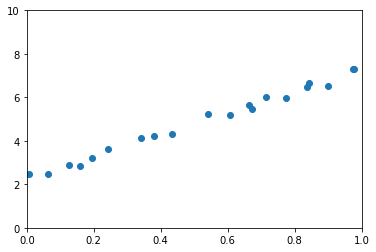

In [7]:
import matplotlib.pyplot as plt
n = 20
X = [random.random() for i in range(20)]
Y = [5*x + 2 + 0.5*random.random() for x in X]
plt.scatter(X, Y)
plt.xlim(0,1)
plt.ylim(0,10)
plt.show()

We'll also use the below helper function for visualizing how we're doing.

In [8]:
def plot_line(X, Y, model, pause_time=1):
  clear_output()
  x_values_plotting = [0,1]
  y_values_plotting = [model.a * x + model.b for x in x_values_plotting]
  plt.plot(x_values_plotting, y_values_plotting, color='red')
  plt.scatter(X, Y)
  plt.xlim(0,1)
  plt.ylim(0,10)
  plt.show()
  time.sleep(pause_time)  

Now, we'll train our linear model using gradient descent and $\ell_2$ loss.

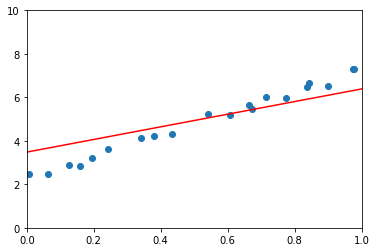

In [9]:
import time
from IPython.display import clear_output

model = Linear()
learning_rate = 0.03
num_epochs = 3
for epoch in range(num_epochs): 
  for (x,y) in zip(X,Y):
    model.zero_grad()
    loss = (model(x)-y)**2
    loss.backward()
    model.a -= learning_rate * model.a.grad
    model.b -= learning_rate * model.b.grad
    plot_line(X, Y, model)
  

### More general datasets

Linear regression works well for data that fits a line. But some data doesn't behave so nicely.

Next, we'll load labelled pairs $(x,y)$ where $x \in \mathbb{R}^2$ and $y \in \{\pm 1\}$. Clearly, a line won't work for us any more. Instead, we'll need a more rich model.

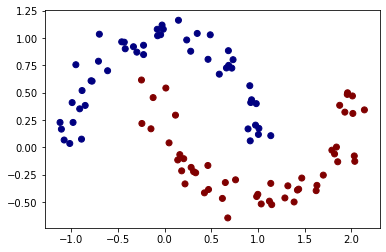

In [10]:
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1)
Y = 2*Y - 1 # go from {0,1} to {-1, 1}

plt.scatter(X[:,0],X[:,1], c=Y, cmap='jet')
plt.show()

Luckily, we have neural networks! Let's build a three layer (two hidden layer) network to solve this problem.

In [11]:
def neuron(weights, inputs, relu=True):
  v = sum(w*x for w,x in zip(weights, inputs))
  return v.relu() if relu else v

class Net:
  # The list comprehension is fancy but this is exactly the architecture
  # we've been drawing in class.
  def __init__(self, hidden_dim=16):
    self.layer_1 = [[Value(), Value()] for i in range(hidden_dim)]
    self.layer_2 = [[Value() for j in range(hidden_dim)] for i in range(hidden_dim)]
    self.output = [Value() for i in range(hidden_dim)]
    self.parameters = [v for L in [self.layer_1,self.layer_2,[self.output]] for w in L for v in w]
  
  def __call__(self, x):
    layer_1_vals = [neuron(w,x) for w in self.layer_1]
    layer_2_vals = [neuron(w, layer_1_vals) for w in self.layer_2]
    return neuron(self.output, layer_2_vals, relu=False)
  
  def zero_grad(self):
    for p in self.parameters:
      p.grad = 0

We'll use the following helper function to visualize how our model is doing.

In [12]:
import numpy as np

def plot_prediction(X, Y, model, title=None, h=.5):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  inputs = [list(map(Value, xrow)) for xrow in Xmesh]
  scores = list(map(model, inputs))
  Z = np.array([s.data > 0 for s in scores])
  Z = Z.reshape(xx.shape)
  
  fig = plt.figure()
  clear_output()
  if title != None: plt.title(title)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.show()

Now let's train our architecture using gradient descent. Notice we're using a slighty non-standard loss. In particular, we want our prediction $y'$ to be close to the true value $y$. In math notation, we want $y y' =1$ so our loss is $1-y y'$. The problem is the model may output really large weights to make this really negative so we need to bound the loss from below at 0.

In [13]:
model = Net(20)

num_epochs = 10
learning_rate = 1
for epoch in range(num_epochs): 
  loss = 0
  for x,y in zip(X,Y):
    output = model(x)
    # want y*output = 1
    # set lowest loss at 0
    loss += (1 + -y*output).relu() 
  loss = loss/len(X) # normalize
  model.zero_grad()
  loss.backward()
  for p in model.parameters:
    p.data -= learning_rate * p.grad   
  accuracy = sum(float(model(x))*y > 0 for x,y in zip(X,Y))/len(X)  
  message = f'Epoch: {epoch}, Loss: {round(loss.data, 2)},  Accuracy: {accuracy*100}'
  print(message)

Epoch: 0, Loss: 0.98,  Accuracy: 79.0
Epoch: 1, Loss: 0.82,  Accuracy: 84.0
Epoch: 2, Loss: 0.37,  Accuracy: 87.0
Epoch: 3, Loss: 0.27,  Accuracy: 87.0
Epoch: 4, Loss: 0.26,  Accuracy: 87.0
Epoch: 5, Loss: 0.26,  Accuracy: 85.0
Epoch: 6, Loss: 0.28,  Accuracy: 87.0
Epoch: 7, Loss: 0.25,  Accuracy: 87.0
Epoch: 8, Loss: 0.25,  Accuracy: 87.0
Epoch: 9, Loss: 0.25,  Accuracy: 87.0


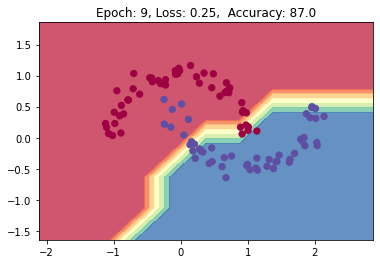

In [14]:
plot_prediction(X, Y, model, title=message, h=.5)

Look how pretty! The neural network is able to fit the data in a way that isn't possible for linear models.